

# Hybrid Model: Mechanistic + Multilayer Perceptron (MLP) Model

## 1. Model Concept

This hybrid model combines:

* **Mechanistic baseline**: the known biological dynamics (f_e → ACh → ICC frequency/amplitude).
* **MLP residual predictor**: a neural network trained to capture residual differences between mechanistic predictions and experimental noisy data.

**Workflow**:

$$
\text{hybrid prediction} = \underbrace{\text{mechanistic baseline}}*{\text{known biology}} + \underbrace{\text{MLP residual}}*{\text{data-driven correction}}
$$

---

## 2. Mechanistic Baseline Equations

The mechanistic baseline is based on Hill functions. For each efferent input $(f_e)$:

### ACh release

$$
\text{ACh}(f_e) = a_\text{Ach} \frac{f_e^{n_\text{Ach}}}{b_\text{Ach}^{n_\text{Ach}} + f_e^{n_\text{Ach}}}
$$

### Excitatory modulation of ICC

$$
\phi_\text{cpm} = a_e^\text{cpm} \frac{\text{ACh}^{n_e^\text{cpm}}}{(b_e^\text{cpm})^{n_e^\text{cpm}} + \text{ACh}^{n_e^\text{cpm}}}, \quad
\phi_\text{amp} = a_e^\text{amp} \frac{\text{ACh}^{n_e^\text{amp}}}{(b_e^\text{amp})^{n_e^\text{amp}} + \text{ACh}^{n_e^\text{amp}}}
$$

### Compute mechanistic baseline ICC values

$$
\text{cpm}_\text{mech} = \text{baseline\_cpm} \cdot (1 + \phi_\text{cpm}), \quad \text{amp}_\text{mech} = \text{baseline\_amp} \cdot (1 + \phi_\text{amp})
$$

> These values are per-row (per-animal) based on CSV `baseline_cpm` and `baseline_amplitude`.

---

## 3. Residual Target for MLP

The MLP predicts residuals between noisy measurements and mechanistic baseline:

$$
\Delta \text{cpm} = \text{cpm}_\text{noisy} - \text{cpm}_\text{mech}, \quad
\Delta \text{amp} = \text{amp}_\text{noisy} - \text{amp}_\text{mech}
$$

**MLP input**:

$$
X = f_{e,\text{antrum}}, \text{ACh}, \text{cpm}_\text{mech}, \text{amp}_\text{mech}
$$

**MLP output**:

$$
\hat{y} = [\Delta \text{cpm}, \Delta \text{amp}]
$$

---

## 4. MLP Structure

The PyTorch **ResidualMLP** consists of:

* **Input layer**: 4 features
* **Hidden layers**: [128, 64] fully connected layers with:

  * ReLU activation
  * Batch normalization (`BatchNorm1d`)
* **Output layer**: 2 features ((\Delta \text{cpm}, \Delta \text{amp}))

### Forward pass equations

$$
h_1 = \text{ReLU}(\text{BatchNorm}(W_1 X + b_1))
$$

$$
h_2 = \text{ReLU}(\text{BatchNorm}(W_2 h_1 + b_2))
$$

$$
\hat{y} = W_3 h_2 + b_3
$$

(\hat{y}) is the predicted residual vector ($\Delta \text{cpm}, \Delta \text{amp}$).

---


## 5. Loss Function and Training

**MSE loss** (per batch):

$$
L = \frac{1}{N} \sum_{i=1}^{N} \Big[ (\Delta \text{cpm}_i - \hat{\Delta \text{cpm}}_i)^2 + (\Delta \text{amp}_i - \hat{\Delta \text{amp}}_i)^2 \Big]
$$

* **Optimizer**: Adam
* **Learning rate schedule**: `ReduceLROnPlateau`
* **Early stopping**: if validation loss doesn’t improve for 40 epochs

**Weight update (gradient descent)**:

$$
W^{(l)} \leftarrow W^{(l)} - \eta \frac{\partial L}{\partial W^{(l)}}, \quad
b^{(l)} \leftarrow b^{(l)} - \eta \frac{\partial L}{\partial b^{(l)}}
$$

---

## 6. Hybrid Prediction

After training, the hybrid model prediction:

$$
\text{cpm}_\text{hybrid} = \text{cpm}_\text{mech} + \hat{\Delta \text{cpm}}, \quad
\text{amp}_\text{hybrid} = \text{amp}_\text{mech} + \hat{\Delta \text{amp}}
$$

Compare these predictions to noisy measurements for evaluation. RMSE is computed for both mechanistic baseline vs noisy and hybrid vs noisy.

---

## 7. Summary of Model Equations

| Component                    | Equation                                                                                                                                                                                                                                                                           |
| ---------------------------- | ---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------- |
| **ACh release**              | $\text{ACh} = a_\text{Ach} \frac{f_e^{n_\text{Ach}}}{b_\text{Ach}^{n_\text{Ach}} + f_e^{n_\text{Ach}}}$                                                                                                                                                                            |
| **ICC modulation**           | $\phi_\text{cpm} = a_e^\text{cpm} \frac{\text{ACh}^{n_e^\text{cpm}}}{(b_e^\text{cpm})^{n_e^\text{cpm}} + \text{ACh}^{n_e^\text{cpm}}}, \quad \phi_\text{amp} = a_e^\text{amp} \frac{\text{ACh}^{n_e^\text{amp}}}{(b_e^\text{amp})^{n_e^\text{amp}} + \text{ACh}^{n_e^\text{amp}}}$ |
| **Mechanistic baseline ICC** | $\text{cpm}_\text{mech} = \text{baseline\_cpm} \cdot (1 + \phi_\text{cpm}), \quad \text{amp}_\text{mech} = \text{baseline\_amp} \cdot (1 + \phi_\text{amp})$ |
| **MLP input**                | $X = [f_e, \text{ACh}, \text{cpm}*\text{mech}, \text{amp}*\text{mech}]$                                                                                                                                                                                                            |
| **MLP output**               | $\hat{y} = [\Delta \text{cpm}, \Delta \text{amp}]$                                                                                                                                                                                                                                 |
| **Loss**                     | $L = \frac{1}{N} \sum_i (\Delta \text{cpm}_i - \hat{\Delta \text{cpm}}_i)^2 + (\Delta \text{amp}_i - \hat{\Delta \text{amp}}_i)^2$                                                                                                                                                 |
| **Hybrid prediction**        | $\text{cpm}_\text{hybrid} = \text{cpm}_\text{mech} + \hat{\Delta \text{cpm}}, \quad \text{amp}_\text{hybrid} = \text{amp}_\text{mech} + \hat{\Delta \text{amp}}$                                                                                                                   |

---

## 8. Key Notes

* The **mechanistic baseline** is fixed and interpretable.
* The MLP captures residual errors/noise or unmodeled dynamics.
* Standardization (scaling) ensures stable training.
* BatchNorm accelerates convergence and reduces covariate shift.
* This approach is modular: the mechanistic baseline can be replaced with more complex dynamics in the future.

Rows: total / train / val / test: 7000 5057 893 1050
Epoch 001  Train loss: 1.074044  Val loss: 1.056721
Epoch 025  Train loss: 0.985828  Val loss: 1.026017
Early stopping at epoch 47. No improvement for 40 epochs.
Training finished. Best val loss: 1.024175574904994
Saved scalers to: scalers.npz
Test RMSE (baseline vs noisy)  cpm: 0.19237871374711682
Test RMSE (hybrid  vs noisy)  cpm: 0.19396904418762975
Test RMSE (baseline vs noisy)  amp: 0.19297177421542164
Test RMSE (hybrid  vs noisy)  amp: 0.19336138511848616


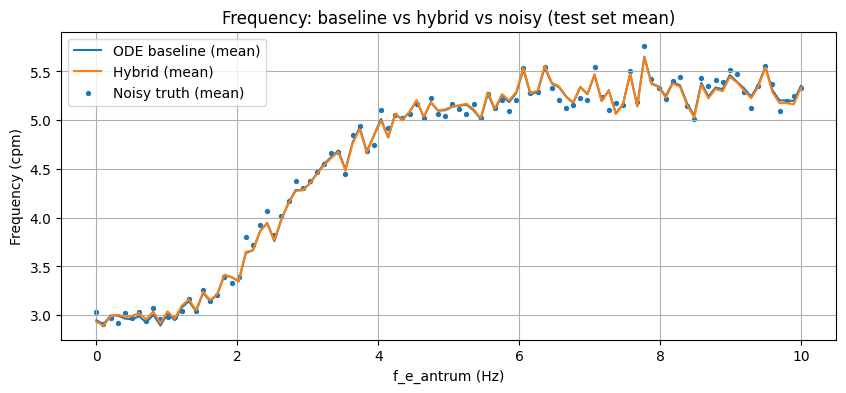

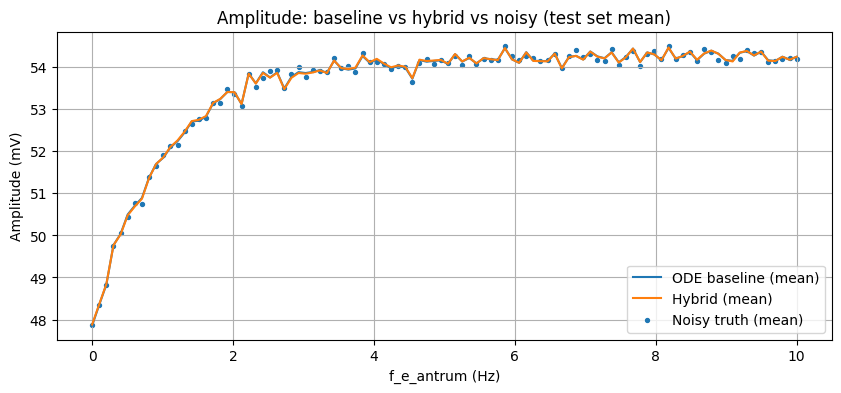

Saved final model to: hybrid_mlp.pth
Saved scalers to: scalers.npz


In [1]:
# Hybrid ODE + MLP template (PyTorch)
# Copy/paste whole block into a Jupyter notebook cell.

# =============================================================================
# Imports
# =============================================================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import os

# =============================================================================
# Config
# =============================================================================
DATA_CSV = "antrum_dataset_all_animals.csv"   # from your earlier generation step
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
BATCH_SIZE = 256
LR = 1e-3
WEIGHT_DECAY = 1e-5
EPOCHS = 400
PATIENCE = 40   # early stopping patience
MODEL_SAVE_PATH = "hybrid_mlp.pth"
SCALER_SAVE_PATH = "scalers.npz"
SEED = 42

torch.manual_seed(SEED)
np.random.seed(SEED)

# =============================================================================
# Recreate ODE baseline (same equations/params you used)
# =============================================================================
# Ach release parameters (must match dataset generation)
a_ach_antrum = 156.4317944
b_ach_antrum = 3.538564077
n_ach_antrum = 3.993133727

# Excitatory modulation of ICC amplitude and frequency by Ach
a_e_amplitude_ICC_antrum = 0.15
b_e_amplitude_ICC_antrum = 0.574457529640854
n_e_amplitude_ICC_antrum = 0.33

a_e_cpm_antrum = 1.3
b_e_cpm_antrum = 96
n_e_cpm_antrum = 1

# =============================================================================
# Utility: compute baseline for given f_e array
# =============================================================================
def compute_baseline_from_fe(f_e_array):
    # f_e_array : np.array
    # returns ach, cpm_ode, amp_ode (np arrays)
    f = np.asarray(f_e_array, dtype=float)
    ach = (a_ach_antrum * (f ** n_ach_antrum)) / ( (b_ach_antrum ** n_ach_antrum) + (f ** n_ach_antrum) )
    phi_amp = (a_e_amplitude_ICC_antrum * (ach ** n_e_amplitude_ICC_antrum)) / ( (b_e_amplitude_ICC_antrum ** n_e_amplitude_ICC_antrum) + (ach ** n_e_amplitude_ICC_antrum) )
    phi_cpm = (a_e_cpm_antrum * (ach ** n_e_cpm_antrum)) / ( (b_e_cpm_antrum ** n_e_cpm_antrum) + (ach ** n_e_cpm_antrum) )
    # For baseline, use mean baseline constants used when synthetic data generated; but per-row baseline was saved in CSV as baseline_cpm/baseline_amplitude
    # We'll compute cpm_ode / amp_ode using the per-row baseline values if available; otherwise use global base.
    return ach, phi_cpm, phi_amp

# =============================================================================
# Load dataset
# =============================================================================
if not os.path.exists(DATA_CSV):
    raise FileNotFoundError(f"Dataset file not found: {DATA_CSV}. Make sure it's in the notebook working directory.")

df = pd.read_csv(DATA_CSV)

# Recompute the ODE baseline values using the same function and per-row baseline values
ach_recalc, phi_cpm_recalc, phi_amp_recalc = compute_baseline_from_fe(df["f_e_antrum"].values)
# Use per-animal baseline_cpm and baseline_amplitude to compute cpm_ode and amp_ode exactly like dataset generation
cpm_ode = df["baseline_cpm"].values * (phi_cpm_recalc + 1.0)
amp_ode = df["baseline_amplitude"].values * (phi_amp_recalc + 1.0)

# Add to dataframe to be explicit
df["ach_recalc"] = ach_recalc
df["cpm_ode"] = cpm_ode
df["amp_ode"] = amp_ode

# Targets: residuals between noisy measurements and ODE baseline
df["d_cpm"] = df["cpm_noisy"] - df["cpm_ode"]
df["d_amp"] = df["amplitude_noisy"] - df["amp_ode"]

# =============================================================================
# Train / valid / test split
# We'll do stratified split by f_e ranges so models see full range
# =============================================================================
trainval_df, test_df = train_test_split(df, test_size=0.15, random_state=SEED, shuffle=True)
train_df, val_df = train_test_split(trainval_df, test_size=0.15, random_state=SEED, shuffle=True)

print("Rows: total / train / val / test:", len(df), len(train_df), len(val_df), len(test_df))

# =============================================================================
# Feature selection and scaling
# Features: f_e_antrum, ach_recalc, cpm_ode, amp_ode
# Targets: d_cpm, d_amp
# =============================================================================
FEATURES = ["f_e_antrum", "ach_recalc", "cpm_ode", "amp_ode"]
TARGETS = ["d_cpm", "d_amp"]

# Fit scalers on training set
X_train = train_df[FEATURES].values
y_train = train_df[TARGETS].values

x_scaler = StandardScaler().fit(X_train)
y_scaler = StandardScaler().fit(y_train)

# Apply scalers
def scale_X(df_in):
    return x_scaler.transform(df_in[FEATURES].values).astype(np.float32)

def scale_y(df_in):
    return y_scaler.transform(df_in[TARGETS].values).astype(np.float32)

# Create PyTorch Dataset
class AntrumResidualsDataset(Dataset):
    def __init__(self, df_in):
        self.X = scale_X(df_in)
        self.y = scale_y(df_in)
    def __len__(self):
        return self.X.shape[0]
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_ds = AntrumResidualsDataset(train_df)
val_ds = AntrumResidualsDataset(val_df)
test_ds = AntrumResidualsDataset(test_df)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, drop_last=False)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False)

# =============================================================================
# Define MLP model (predicts 2 residuals)
# =============================================================================
class ResidualMLP(nn.Module):
    def __init__(self, in_dim=4, hidden=[64,64], out_dim=2):
        super().__init__()
        layers = []
        prev = in_dim
        for h in hidden:
            layers.append(nn.Linear(prev, h))
            layers.append(nn.ReLU())
            layers.append(nn.BatchNorm1d(h))
            prev = h
        layers.append(nn.Linear(prev, out_dim))
        self.net = nn.Sequential(*layers)
    def forward(self, x):
        return self.net(x)

# Instantiate
net = ResidualMLP(in_dim=len(FEATURES), hidden=[128,64], out_dim=2).to(DEVICE)
optimizer = torch.optim.Adam(net.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, patience=10)
loss_fn = nn.MSELoss()

# =============================================================================
# Training loop with early stopping (tracks validation loss)
# =============================================================================
best_val = np.inf
epochs_no_improve = 0
history = {"train_loss":[], "val_loss":[]}

for epoch in range(1, EPOCHS+1):
    net.train()
    running_loss = 0.0
    for Xbatch, ybatch in train_loader:
        Xbatch = Xbatch.to(DEVICE)
        ybatch = ybatch.to(DEVICE)
        optimizer.zero_grad()
        pred = net(Xbatch)
        loss = loss_fn(pred, ybatch)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * Xbatch.size(0)
    train_loss = running_loss / len(train_loader.dataset)

    # Validation
    net.eval()
    running_val = 0.0
    with torch.no_grad():
        for Xv, yv in val_loader:
            Xv = Xv.to(DEVICE); yv = yv.to(DEVICE)
            pv = net(Xv)
            lossv = loss_fn(pv, yv)
            running_val += lossv.item() * Xv.size(0)
    val_loss = running_val / len(val_loader.dataset)
    scheduler.step(val_loss)

    history["train_loss"].append(train_loss)
    history["val_loss"].append(val_loss)

    if val_loss < best_val - 1e-9:
        best_val = val_loss
        torch.save(net.state_dict(), MODEL_SAVE_PATH)
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1

    if epoch % 25 == 0 or epoch == 1:
        print(f"Epoch {epoch:03d}  Train loss: {train_loss:.6f}  Val loss: {val_loss:.6f}")

    if epochs_no_improve >= PATIENCE:
        print(f"Early stopping at epoch {epoch}. No improvement for {PATIENCE} epochs.")
        break

# Load best model
net.load_state_dict(torch.load(MODEL_SAVE_PATH, map_location=DEVICE))
net.to(DEVICE)
print("Training finished. Best val loss:", best_val)

# Save scalers
np.savez(SCALER_SAVE_PATH,
         x_mean=x_scaler.mean_, x_scale=x_scaler.scale_,
         y_mean=y_scaler.mean_, y_scale=y_scaler.scale_)
print("Saved scalers to:", SCALER_SAVE_PATH)

# =============================================================================
# Evaluation on test set: compute baseline, hybrid prediction and compare to noisy truth
# =============================================================================
net.eval()
# Build arrays for plotting from test_df (unscaled)
X_test = test_df[FEATURES].values.astype(np.float32)
y_test = test_df[TARGETS].values.astype(np.float32)

# Scale X for forward pass
X_test_scaled = x_scaler.transform(X_test).astype(np.float32)
with torch.no_grad():
    X_tensor = torch.from_numpy(X_test_scaled).to(DEVICE)
    pred_scaled = net(X_tensor).cpu().numpy()
# Unscale predicted residuals
pred_resid = y_scaler.inverse_transform(pred_scaled)

# Baseline predictions (ode)
cpm_baseline_test = test_df["cpm_ode"].values
amp_baseline_test = test_df["amp_ode"].values

# Hybrid predictions = baseline + predicted residual
cpm_hybrid = cpm_baseline_test + pred_resid[:,0]
amp_hybrid = amp_baseline_test + pred_resid[:,1]

# Noisy ground truth
cpm_noisy_test = test_df["cpm_noisy"].values
amp_noisy_test = test_df["amplitude_noisy"].values

# Compute RMSEs
def rmse(a,b): return np.sqrt(np.mean((a-b)**2))
print("Test RMSE (baseline vs noisy)  cpm:", rmse(cpm_baseline_test, cpm_noisy_test))
print("Test RMSE (hybrid  vs noisy)  cpm:", rmse(cpm_hybrid, cpm_noisy_test))
print("Test RMSE (baseline vs noisy)  amp:", rmse(amp_baseline_test, amp_noisy_test))
print("Test RMSE (hybrid  vs noisy)  amp:", rmse(amp_hybrid, amp_noisy_test))

# =============================================================================
# Visualization: pick a few animals / fe ranges and plot baseline vs hybrid vs noisy
# =============================================================================
# Add results to a DataFrame for easier plotting
test_df_plot = test_df.copy().reset_index(drop=True)
test_df_plot["cpm_hybrid"] = cpm_hybrid
test_df_plot["amp_hybrid"] = amp_hybrid

# We'll plot averaged curves across animals for 0-10Hz
# Group by f_e_antrum and compute means for baseline/noisy/hybrid
plot_df = test_df_plot.groupby("f_e_antrum").agg({
    "cpm_ode":"mean",
    "cpm_noisy":"mean",
    "cpm_hybrid":"mean",
    "amp_ode":"mean",
    "amplitude_noisy":"mean",
    "amp_hybrid":"mean"
}).reset_index()

plt.figure(figsize=(10,4))
plt.plot(plot_df["f_e_antrum"], plot_df["cpm_ode"], label="ODE baseline (mean)")
plt.plot(plot_df["f_e_antrum"], plot_df["cpm_hybrid"], label="Hybrid (mean)")
plt.scatter(plot_df["f_e_antrum"], plot_df["cpm_noisy"], s=8, label="Noisy truth (mean)")
plt.xlabel("f_e_antrum (Hz)")
plt.ylabel("Frequency (cpm)")
plt.legend()
plt.title("Frequency: baseline vs hybrid vs noisy (test set mean)")
plt.grid(True)
plt.show()

plt.figure(figsize=(10,4))
plt.plot(plot_df["f_e_antrum"], plot_df["amp_ode"], label="ODE baseline (mean)")
plt.plot(plot_df["f_e_antrum"], plot_df["amp_hybrid"], label="Hybrid (mean)")
plt.scatter(plot_df["f_e_antrum"], plot_df["amplitude_noisy"], s=8, label="Noisy truth (mean)")
plt.xlabel("f_e_antrum (Hz)")
plt.ylabel("Amplitude (mV)")
plt.legend()
plt.title("Amplitude: baseline vs hybrid vs noisy (test set mean)")
plt.grid(True)
plt.show()

# =============================================================================
# Save final model (already saved best during training) and scalers
# =============================================================================
print("Saved final model to:", MODEL_SAVE_PATH)
print("Saved scalers to:", SCALER_SAVE_PATH)

# You can reload model later with:
# model = ResidualMLP(in_dim=4, hidden=[128,64], out_dim=2)
# model.load_state_dict(torch.load("hybrid_mlp.pth"))
# model.eval()